In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score

from utils import save_plotly_figure_as_html
from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
from ex_04_my_kmeans import MyKMeans


In [2]:
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_04")
plot_path.mkdir(parents=True, exist_ok=True)


data, labels, exp_ids = get_welding_data(data_path, n_samples=5_000)

## Exercise 4.2: Optimal Cluster Selection

Implement the elbow method to find the optimal number of clusters for the raw time series data using your implement of the kmeans algorithm (MyKMeans).

1. Calculate the distortion (inertia) for different values of k (1 to 10)
2. Plot the results to identify the "elbow point" with matplotlib where adding more clusters produces diminishing returns
3. This will help determine the most appropriate number of clusters for our welding data

KMeans:  52%|█████▏    | 52/100 [10:07<09:20, 11.69s/iter, inertia=5.46e+8]


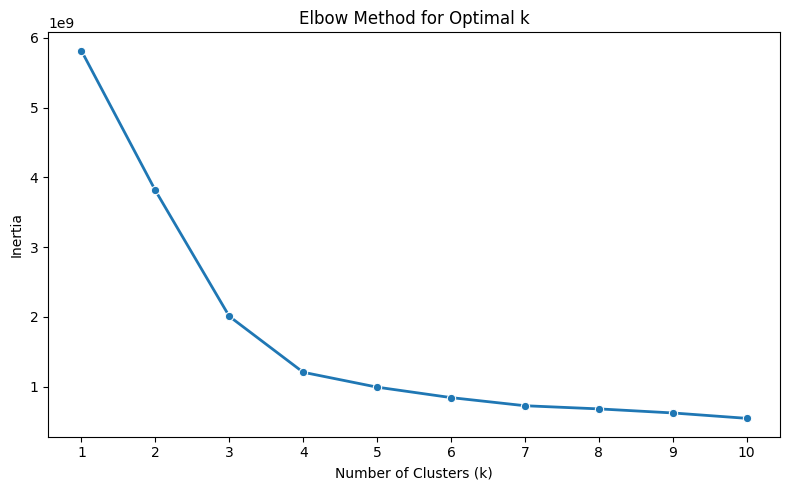

In [44]:
def elbow_method(X, max_clusters=10, distance_metric="euclidean", filename="plot.png"):
    """
    Apply the elbow method to find the optimal number of clusters.
    
    Args:
        X: Feature matrix (scaled)
        max_clusters: Maximum number of clusters to try
        distance_metric: Distance metric to use
    """
    inertia_per_k = []

    for i in range(max_clusters):
        kmeans = MyKMeans(k=i+1, distance_metric=distance_metric)
        kmeans.fit(X)
        inertia_per_k.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=np.arange(1,max_clusters+1), y=inertia_per_k, marker="o", linewidth=2)

    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(np.arange(1,max_clusters+1))
    plt.tight_layout()

    plt.savefig(plot_path / filename)


elbow_method(data, filename="data_elbow.png")

## Exercise 4.3: Clustering with MyKMeans

### Based on the elbow curve above, explain your choice of k:

1. What does the shape of the elbow curve tell you about the underlying data structure?
2. Why did you select this specific number of clusters?
   - Consider the plot and the elbow method to justify your choice
   - How might this choice affect the interpretability of the resulting clusters?

#### Answers:
1. The more clusters are created, the better they can seperate the data, i.e. they incrementally reduce entropy within each cluster.
2. I selected **k=3** clusters, since that is the approximate point where the "elbow" plot "creases" and the line begins to fall slower. Adding more clusters would only improve cluster seperation marginally and might seperate similar data points into multiple clusters despite their similarily. However the plot is not completely definitive, so a selection of k = 4 might be adequate as well.

### KMeans with euclidean distance and dtw distance
1. run K means with your selected k 


In [ ]:
# optional data standardization step
#data_z = (data - data.mean()) / data.std() 

kmeans_euclidian = MyKMeans(k=3, distance_metric="euclidean")
kmeans_euclidian.fit(data)

kmeans_dtw = MyKMeans(k=3, distance_metric="dtw")
kmeans_dtw.fit(data)

KMeans:  12%|█▏        | 12/100 [01:17<09:27,  6.45s/iter, inertia=340]


## Exercise 4.4: Cluster Visualization

Plot the mean time series (centroids) for each cluster to visualize and understand the patterns.

Remember that our welding data has both current and voltage measurements over time (shape: n_samples, sequence_length, features). For each cluster:
1. Plot the average current pattern
2. Plot the average voltage pattern
3. Look for distinctive characteristics in each cluster that might relate to welding quality

This visualization will help identify what makes each cluster unique in terms of temporal patterns.

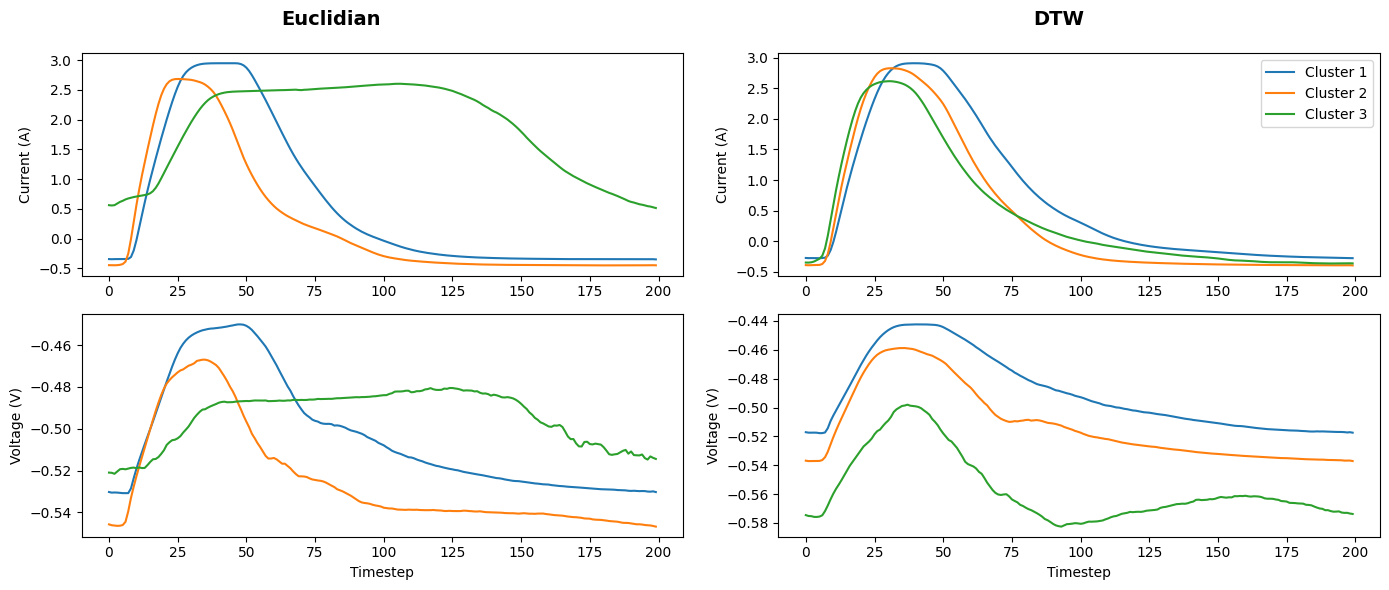

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=False)

centroid_groups = [kmeans_euclidian.centroids, kmeans_dtw.centroids]
feature_labels = ["Current (A)", "Voltage (V)"]

for dataset_idx in range(len(centroid_groups)):
    col_data = centroid_groups[dataset_idx]
    for feature_idx in range(col_data.shape[2]):
        ax = axes[feature_idx, dataset_idx]
        for cluster_idx in range(col_data.shape[0]):
            ax.plot(
                range(col_data.shape[1]),
                col_data[cluster_idx, :, feature_idx],
                label=f"Cluster {cluster_idx+1}"
            )
        ax.set_ylabel(feature_labels[feature_idx])
        if feature_idx == 1:
            ax.set_xlabel("Timestep")
        if dataset_idx == 1 and feature_idx == 0:
            ax.legend()


fig.text(0.24, 0.95, "Euclidian", ha="center", fontsize=14, fontweight="bold")
fig.text(0.76, 0.95, "DTW", ha="center", fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space at top for column titles
plt.savefig(plot_path / "cluster_visualization.png")
plt.show()

## Exercise 4.5: Feature-Based Clustering

Now we'll use the engineered features extracted in Exercise 3 instead of raw time series data. Therefore, you can use the euclidean distance metric.

1. Load your extracted features from exercise 3 
2. Split them into data and labels
3. Scale the data for better clustering performance
4. Apply the elbow method again to determine the optimal number of clusters for the feature-based approach
5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?
   - Which approach might better capture the relevant patterns for quality assessment?


In [49]:
# Extract features from the data
features = extract_features(data, labels)

# separate data and labels
feature_quality_labels = features.iloc[:, -1]
feature_data = features.iloc[:, :-1]

KMeans:  29%|██▉       | 29/100 [00:15<00:38,  1.83iter/s, inertia=2.98e+4]


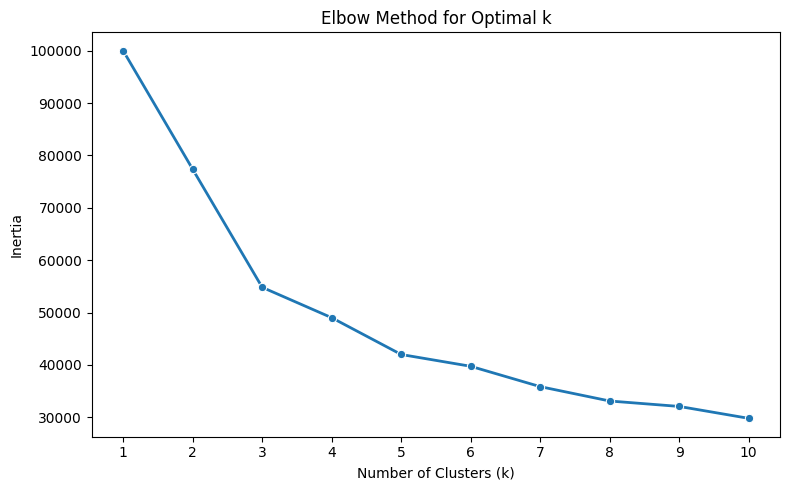

In [50]:
feature_data_z = (feature_data - feature_data.mean()) / feature_data.std()

elbow_method(feature_data_z, filename="features_elbow.png")


#### Answers:

5. Inertia is much lower overall in the feature clustering approach, which may be in part due to the standardization of feature data to the z-scale before analysis. Additionally the elbow point is much more pronounced in the feature diagram that in the raw time series data diagram, suggesting a more certain decision point for a **k value of 3**.
    - Raw data likely represents clusters better, when the deciding differences between clusters lie in the passage of current/voltage values over time, e.g. certain patterns of spikes. If the overall magnitude of values is central however, features may be better in representing clusters, as they can highlight generalized trends.

## Exercise 4.6: Advanced 3D Visualization

Visualize the clustering results using interactive 3D plots with Plotly.

1. Use PCA to reduce the dimensionality of our feature space to 3 components
2. Create two visualizations:
   - Points colored by assigned cluster
   - Same points colored by actual quality labels
3. Include the explained variance for each principal component in the axis labels
4. Save the figures to the plot_path


This visualization will help us understand how well our clustering approach aligns with the known quality designations.

#### Note:
- You can use the following links to find more information about the PCA:
   - https://en.wikipedia.org/wiki/Principal_component_analysis
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [ ]:
# run pca on z-transformed feature data
pca = PCA(n_components=3)
features_pca = pca.fit_transform(feature_data_z)

# determine clusters in pca data
features_kmeans = MyKMeans(k=3)
cluster_labels = features_kmeans.fit_predict(features_pca)

# prepare df of pca data for visualisation
df_pca = pd.DataFrame(features_pca, columns=["PC1", "PC2", "PC3"])
df_pca["cluster"] = cluster_labels.astype(str)
df_pca["labels"] = feature_quality_labels.astype(str)

color_map1 = ["orange", "red", "blue"]
color_map2 = ["blue", "darkred"]

# create 3d plots
fig1 = px.scatter_3d(
    df_pca,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    color_discrete_sequence=color_map1
)
fig1.update_layout(title="3D Clustering Results")

fig2 = px.scatter_3d(
    df_pca,
    x="PC1", y="PC2", z="PC3",
    color="labels",
    color_discrete_sequence=color_map2
)
fig2.update_layout(title="Actual Quality Labels")

# save plots
fig1_save_path = save_plotly_figure_as_html(fig1, plot_path / f'clusters_3d_{3}_clusters')
fig2_save_path = save_plotly_figure_as_html(fig2, plot_path / f'quality_3d_{3}_clusters')

KMeans:   9%|▉         | 9/100 [00:00<00:06, 14.44iter/s, inertia=2.69e+4]


ARI: 0.1432793293963543


## Exercise 4.7: Analysis and Interpretation

Analyze the clustering results in depth and discuss their implications:

1. Cluster separation:
   - How well do clusters separate different quality levels?
   - What is the Adjusted Rand Index between clusters and quality labels?
   - Are there clusters that predominantly contain good or bad welds?

2. Feature importance:
   - Which features seem most important for distinguishing clusters?
   - How does the PCA visualization help us understand the data structure?

3. Process insights:
   - What insights could these clusters provide for improving the welding process?
   - Could certain clusters identify specific types of welding issues?

4. Limitations:
   - What are the limitations of using clustering for quality assessment?
   - How might the approach be improved in future iterations?



In [72]:
# gather information about the clustering

# adjusted rand index
ari = adjusted_rand_score(feature_quality_labels, cluster_labels)
print("Adjusted Rand Index:", ari)

print("\n---------------\n")

# quality count per cluster
print("Quality Labels per Cluster:")
counts = pd.crosstab(feature_quality_labels, cluster_labels, rownames=['Quality'], colnames=['Cluster'])
print(counts)

print("\n---------------\n")

print("PCA Component Loading from original data")
loadings = pd.DataFrame(
    pca.components_.T,  # transpose to get features as rows
    index=feature_data_z.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

top_features = {}

for pc in loadings.columns:
    top = loadings[pc].abs().nlargest(3)  # Get top 3 by absolute value
    top_with_values = loadings.loc[top.index, pc]  # Get actual signed values
    top_features[pc] = top_with_values

# Display results
for pc, series in top_features.items():
    formatted = ", ".join(f"{feature} ({value:.4f})" for feature, value in series.items())
    print(f"  {pc}: {formatted}")


Adjusted Rand Index: 0.1432793293963543

---------------

Quality Labels per Cluster:
Cluster     0     1    2
Quality                 
0         566  2257  104
1        1142   904   27

---------------

PCA Component Loading from original data
  PC1: power_mean (0.3542), power_min (0.3161), curr_mean (0.3013)
  PC2: power_std (0.3842), power_max (0.3842), curr_std (0.3482)
  PC3: volt_min (0.4550), volt_std (-0.4227), volt_time_to_peak (-0.4047)


#### Answers:
1.
    - On visual inspection, the clusters don't appear to seperate the quality levels much.
    - The Adjusted Rand Index is approx. 0.1433
    - Cluster 0 seems to contain more good welds than clusters 1 and 2.

2.
    - PCA feature loadings suggest the most crucial featuers to be:
        - Power mean, min, max, standard deviation
        - Current mean, standard deviation
        - Voltage min, standard deviation, time to peak
    - PCA visualisation allows some amount of identification of patterns seen in the pairplots of Exercise 3.3, especially the significance of power variables.

3.
    - Certain patterns of weld data that seem to produce mostly bad welds might be easily identifiable, such as cluster 2, which shows significant difference to the other two clusters and contains 80% bad welds. Therefore this may allow steps to be taken to either quickly scrap the bad weld or introduce swift steps to fix the faulty weld.
    - It is unlikely, but not impossible, that these clusters may differentiate different types of errores, as one cluster group is considerably smaller than the other (131 in cluster 3 vs. 3161 in cluster 1 and 1708 in cluster 0). However since cluster 2 has ~80% bad welds and cluster 1 ~70%, there may be some difference between error type identifiable (cluster 0 contains ~33% bad welds).

4.
    - Interpretabiltiy of clusters is limited, even after viewing PCA component loadings. Since the clusters are not perfectly formed, some amount of grouping may also have been mistakenly adapted to outliers.
    - The process could be repeated for more feature combinations and slight changes to the amount of clusters (i.e. 2 or 4 instead of 3) and then visualizations and quality parameters such as the Adjusted Rand Index or PCA component loadings could be compared to find an optimum combination. Experts may also be consulted to view clustering results and perhaps identify known patterns in the data, especially in raw time series clusters.